# PyLops - Class-based solvers in v2

This notebook provides a tour of the new class-based solvers in PyLops and how they can be invoked with different level of abstraction (more abstraction <-> less flexibility)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops
from scipy.sparse.linalg import cg as sp_cg
from pylops.optimization.basicc import CG, CGLS, LSQR
from pylops.optimization.leastsquaresc import NormalEquationsInversion, RegularizedInversion, PreconditionedInversion
from pylops.optimization.basic import cg, cgls, lsqr
from pylops.optimization.leastsquares import normal_equations_inversion, regularized_inversion, preconditioned_inversion
from pylops.optimization.solver_old import cg as cg_old
from pylops.optimization.solver_old import cgls as cgls_old
from pylops.optimization.solver_old import lsqr as lsqr_old
from pylops.optimization.leastsquares_old import NormalEquationsInversion as normal_equations_inversion_old
from pylops.optimization.leastsquares_old import RegularizedInversion as regularized_inversion_old
from pylops.optimization.leastsquares_old import PreconditionedInversion as preconditioned_inversion_old

## CG

In [2]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

In [3]:
def callback(xx, xhist):
    #print(f'Ciao {xx}')
    xhist.append(xx.copy())

### Step-by-step solver

The most verbose of the options:

- Create the solver object
- Setup the solver with data, solver hyperparameters (and, optionally, the initial guess). This will return the initial guess to be passed to step
- Step the solver Niter times passing x (at iter i-1) and obtaining x (at iter i)
- Optionally interleave step with callback
- Finalize solver

In [4]:
cgsolve = CG(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
for i in range(ny):
    x = cgsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
cgsolve.finalize(True)
xest = x.copy()

CG
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00
-----------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4359e-05
    41         1.0000e+00         5.0076e-08
    51         1.0000e+00         7.1325e-12
    61         1.0000e+00         3.7793e-23
    71         1.0000e+00         3.9676e-27
    81         1.0000e+00         8.8582e-31
    91         1.0000e+00         4.5517e-34

Iterations = 100        Total time (s) = 0.01
-----------------------------------------------------------------



In [5]:
xhist[0]

array([ 0.00623054, -0.08018339,  0.39960984,  0.62411442,  1.08859636,
        0.38381985,  0.6964201 ,  1.04585291,  0.75853243,  0.68292631,
        0.3161173 ,  0.27607787,  0.72731135,  0.52669676,  0.11739324,
        0.14758833,  0.85023401,  0.80690362,  1.26129193,  0.48751973,
        0.12586797,  0.88287304,  0.81393472,  0.81674471,  0.17009951,
       -0.10212194,  1.09518642,  1.10737678,  0.00483318,  0.71825152,
        0.41483263,  0.92885864,  0.72719834,  0.30835651,  0.00494972,
        0.39449335, -0.01485279,  0.1739736 ,  0.97196505,  0.24290925,
        0.98533785,  0.3677009 ,  0.6948482 ,  0.82346676,  1.19474566,
        0.91422985,  0.67712503,  0.64024807,  0.68718705,  0.89545759])

In [6]:
cgsolve = CG(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
x = cgsolve.run(x, ny, show=True)
cgsolve.finalize(True)
xest = x.copy()

CG
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00
-----------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
     5         1.0986e+00         2.8867e+01
     6         1.0980e+00         1.7638e+01
     7         1.0594e+00         1.1285e+01
     8         1.0419e+00         7.3059e+00
     9         1.0396e+00         5.4244e+00
    10         1.0275e+00         3.8095e+00
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4359e-05
    41         1.0000e+00         5.0076e-08
    51         1.0000e+00         7.1325e-12
    61         1.0000e+00         3.7793e-23
    71         1.0000e+00         3.9676e-27
    81    

### Class based solver

The second most verbose of the options:

- Create the solver object
- Run the solve method with data, initial model and solver hyperparameters

In [7]:
# class based solver
cgsolve = CG(Aop)
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=True, itershow=[4,3,10])[0]

CG
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4359e-05
    41         1.0000e+00         5.0076e-08
    51         1.0000e+00         7.1325e-12
    61         1.0000e+00         3.7793e-23
    71         1.0000e+00         3.9676e-27
    81         1.0000e+00         8.8582e-31
    91         1.0000e+00         4.5517e-34
    99         1.0000e+00         1.4835e-37
   100         1.0000e+00         6.4710e-38

Iterations = 100        Total time (s) = 0.01
-----------------------------------------

### Function based solver

The least verbose of the options (like in PyLops v1). Simply call the function equivalent of the solver that is a thin wrapper around what just did in the previous code block.

In [8]:
xhist = []
xest2 = cg(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True, 
           callback=lambda x: callback(x, xhist))[0]
xest3 = cg_old(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True)[0]

CG
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn           x[0]              r2norm
     1         6.2305e-03         3.2678e+02
     2         5.4117e-01         1.4894e+02
     3         8.2224e-01         7.2608e+01
     4         9.1420e-01         4.7116e+01
     5         1.0986e+00         2.8867e+01
     6         1.0980e+00         1.7638e+01
     7         1.0594e+00         1.1285e+01
     8         1.0419e+00         7.3059e+00
     9         1.0396e+00         5.4244e+00
    10         1.0275e+00         3.8095e+00
    11         1.0200e+00         2.6365e+00
    21         9.9997e-01         2.2388e-02
    31         1.0000e+00         8.4359e-05
    41         1.0000e+00         5.0076e-08
    51         1.0000e+00         7.1325e-12
    61         1.0000e+00         3.7793e-23
    71         1.0000e+00         3.9676e-2

In [9]:
xhist[0]

array([ 0.00623054, -0.08018339,  0.39960984,  0.62411442,  1.08859636,
        0.38381985,  0.6964201 ,  1.04585291,  0.75853243,  0.68292631,
        0.3161173 ,  0.27607787,  0.72731135,  0.52669676,  0.11739324,
        0.14758833,  0.85023401,  0.80690362,  1.26129193,  0.48751973,
        0.12586797,  0.88287304,  0.81393472,  0.81674471,  0.17009951,
       -0.10212194,  1.09518642,  1.10737678,  0.00483318,  0.71825152,
        0.41483263,  0.92885864,  0.72719834,  0.30835651,  0.00494972,
        0.39449335, -0.01485279,  0.1739736 ,  0.97196505,  0.24290925,
        0.98533785,  0.3677009 ,  0.6948482 ,  0.82346676,  1.19474566,
        0.91422985,  0.67712503,  0.64024807,  0.68718705,  0.89545759])

(0.0, 2.0)

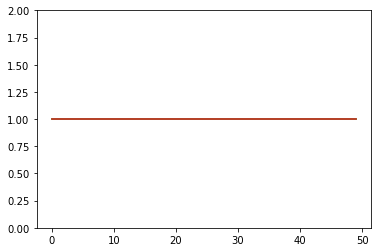

In [10]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2)

In [11]:
xest-xest1, xest1-xest2, xest1-xest3

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

## CG with complex numbers

In [12]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

In [13]:
# function based solver
xest2 = cg(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]#, callback=callback)[0]
xest3 = cg_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]

CG
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn              x[0]                  r2norm
     1        5.17e-01+5.17e-01j         4.5201e+02
     2        7.99e-01+7.99e-01j         1.9958e+02
     3        9.80e-01+9.80e-01j         1.2913e+02
     4        1.15e+00+1.15e+00j         7.1300e+01
     5        1.20e+00+1.20e+00j         4.5552e+01
     6        1.16e+00+1.16e+00j         3.2619e+01
     7        1.08e+00+1.08e+00j         1.4674e+01
     8        1.06e+00+1.06e+00j         1.1070e+01
     9        1.02e+00+1.02e+00j         9.0341e+00
    10        1.00e+00+1.00e+00j         4.8805e+00
    11        9.98e-01+9.98e-01j         3.1756e+00
    21        1.00e+00+1.00e+00j         3.6058e-02
    31        1.00e+00+1.00e+00j         1.8360e-04
    41        1.00e+00+1.00e+00j         8.4551e-07
    51        1.00e+00+1.00e

## CG with multiple RHS (just to remember it does not work right now!)

# CGLS

In [14]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [15]:
def callback(xx, xhist):
    #print(f'Ciao {xx}')
    xhist.append(xx.copy())

## Step-by-step solver

In [16]:
cgsolve = CGLS(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
for i in range(ny):
    x = cgsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
cgsolve.finalize(True)
xest = x.copy()

CGLS
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	
-----------------------------------------------------------
    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    31        1.0000e+00         1.2494e-05     1.2494e-05
    41        1.0000e+00         1.1135e-08     1.1135e-08
    51        1.0000e+00         9.6590e-13     9.6590e-13
    61        1.0000e+00         1.2919e-14     1.2919e-14
    71        1.0000e+00         1.2919e-14     1.2919e-14
    81        1.0000e+00         1.2919e-14     1.2919e-14
    91        1.0000e+00         1.2919e-14     1.2919e-14

Iterations = 100        Total time (s) = 0.01
-----------------------------------------------------------------



## Class based solver

In [17]:
# class based solver
cgsolve = CGLS(Aop)
xest1 = cgsolve.solve(y=y, x0=np.zeros(nx), tol=0, 
                      niter=ny, show=True, itershow=[4,3,10])[0]

CGLS
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    31        1.0000e+00         1.2494e-05     1.2494e-05
    41        1.0000e+00         1.1135e-08     1.1135e-08
    51        1.0000e+00         9.6590e-13     9.6590e-13
    61        1.0000e+00         1.2919e-14     1.2919e-14
    71        1.0000e+00         1.2919e-14     1.2919e-14
    81        1.0000e+00         1.2919e-14     1.2919e-14
    91        1.00

## Function based solver

In [18]:
xhist = []
xest2 = cgls(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True, 
           callback=lambda x: callback(x, xhist))[0]
xest3 = cgls_old(Aop, y, np.zeros(nx), niter=ny, tol=0, show=True)[0]

CGLS
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn          x[0]              r1norm         r2norm
     1        6.2305e-03         3.1506e+01     3.1506e+01
     2        5.4117e-01         1.5690e+01     1.5690e+01
     3        8.2224e-01         9.2479e+00     9.2479e+00
     4        9.1420e-01         6.3248e+00     6.3248e+00
     5        1.0986e+00         3.7566e+00     3.7566e+00
     6        1.0980e+00         2.3773e+00     2.3773e+00
     7        1.0594e+00         1.5883e+00     1.5883e+00
     8        1.0419e+00         1.1075e+00     1.1075e+00
     9        1.0396e+00         7.8965e-01     7.8965e-01
    10        1.0275e+00         5.7929e-01     5.7929e-01
    11        1.0200e+00         3.8881e-01     3.8881e-01
    21        9.9997e-01         3.2320e-03     3.2320e-03
    31        1.00

(0.0, 2.0)

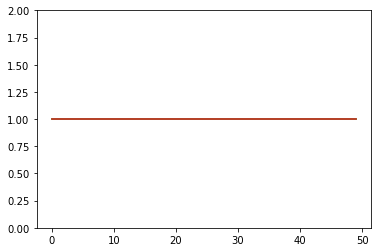

In [19]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2)

## CGLS with complex numbers

In [20]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [21]:
# function based solver
xest2 = cgls(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]#, callback=callback)[0]
xest3 = cgls_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, tol=0, show=True)[0]

CGLS
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 100
-----------------------------------------------------------
    Itn             x[0]             r1norm         r2norm
     1       5.17e-01+5.17e-01j    4.6880e+01     4.6880e+01
     2       7.99e-01+7.99e-01j    2.4899e+01     2.4899e+01
     3       9.80e-01+9.80e-01j    1.5539e+01     1.5539e+01
     4       1.15e+00+1.15e+00j    9.2586e+00     9.2586e+00
     5       1.20e+00+1.20e+00j    5.9991e+00     5.9991e+00
     6       1.16e+00+1.16e+00j    3.7820e+00     3.7820e+00
     7       1.08e+00+1.08e+00j    2.4593e+00     2.4593e+00
     8       1.06e+00+1.06e+00j    1.7537e+00     1.7537e+00
     9       1.02e+00+1.02e+00j    1.1751e+00     1.1751e+00
    10       1.00e+00+1.00e+00j    6.7791e-01     6.7791e-01
    11       9.98e-01+9.98e-01j    4.2278e-01     4.2278e-01
    21       1.00e+00+1.00e+00j    5.3401e-03     5.3

In [22]:
xest2-xest3

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

# LSQR

In [23]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [24]:
def callback(xx, xhist):
    #print(f'Ciao {xx}')
    xhist.append(xx.copy())

## Step-by-step solver

In [25]:
lsqrsolve = LSQR(Aop)

xhist = []
lsqrsolve.callback = lambda x: callback(x, xhist)

x = lsqrsolve.setup(y=y, x0=np.zeros(nx), atol=0, show=True)
for i in range(ny):
    x = lsqrsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
lsqrsolve.finalize(True)
xest = x.copy()

LSQR
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       10
-----------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
    11  1.0200e+00  3.888e-01  3.888e-01   5.4e-03  3.0e-03  4.0e+01  1.6e+01
    21  9.9997e-01  3.232e-03  3.232e-03   4.5e-05  2.5e-05  5.2e+01  3.2e+01
    31  1.0000e+00  1.249e-05  1.249e-05   1.7e-07  9.6e-08  6.1e+01  4.7e+01
    41  1.0000e+00  8.147e-09  8.147e-09   1.1e-10  9.3e-11  6.9e+01  6.1e+01
    51  1.0000e+00  9.661e-13  9.661e-13   1.3e-14  8.1e-15  7.7e+01  7.4e+01
    61  1.0000e+00  9.996e-15  9.996e-15   1.4e-16  2.4e-25  8.5e+01  9.1e+01
  

## Class based solver

In [26]:
# class based solver
lsqrsolve = LSQR(Aop)
xest1 = lsqrsolve.solve(y=y, x0=np.zeros(nx), atol=0, btol=0, 
                        niter=ny, show=True, itershow=[4,3,10])[0]

LSQR
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00                 niter =      100
-----------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
     2  5.4117e-01  1.569e+01  1.569e+01   2.2e-01  1.7e-01  1.9e+01  2.2e+00
     3  8.2224e-01  9.248e+00  9.248e+00   1.3e-01  8.2e-02  2.3e+01  3.4e+00
     4  9.1420e-01  6.325e+00  6.325e+00   8.7e-02  5.3e-02  2.6e+01  4.7e+00
    11  1.0200e+00  3.888e-01  3.888e-01   5.4e-03  3.0e-03  4.0e+01  1.6e+01
    21  9.9997e-01  3.232e-03  3.232e-03   4.5e-05  2.5e-05  5.2e+01  3.2e+01
    31  1.0000e+00  1.249e-05  1.249e-05   1.7e-07  9.6e-08  6.1e+01  4.7e+01
  

## Function based solver

In [27]:
xhist = []
xest2 = lsqr(Aop, y, np.zeros(nx), niter=ny, atol=0, show=True, 
             callback=lambda x: callback(x, xhist))[0]
xest3 = lsqr_old(Aop, y, np.zeros(nx), niter=ny, atol=0, show=True)[0]

LSQR
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =      100
-----------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  7.253e+01  7.253e+01   1.0e+00  1.7e-01
     1  6.2305e-03  3.151e+01  3.151e+01   4.3e-01  3.7e-01  1.4e+01  1.0e+00
     2  5.4117e-01  1.569e+01  1.569e+01   2.2e-01  1.7e-01  1.9e+01  2.2e+00
     3  8.2224e-01  9.248e+00  9.248e+00   1.3e-01  8.2e-02  2.3e+01  3.4e+00
     4  9.1420e-01  6.325e+00  6.325e+00   8.7e-02  5.3e-02  2.6e+01  4.7e+00
     5  1.0986e+00  3.757e+00  3.757e+00   5.2e-02  3.3e-02  2.8e+01  6.4e+00
     6  1.0980e+00  2.377e+00  2.377e+00   3.3e-02  2.0e-02  3.1e+01  7.9e+00
     7  1.0594e+00  1.588e+00  1.588e+00   2.2e-02  1.3e-02  3.3e+01  9.5e+00
  

(0.0, 2.0)

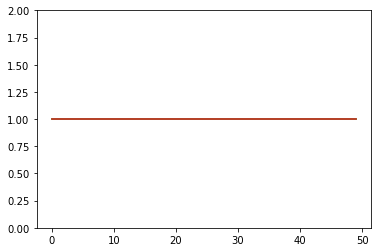

In [28]:
plt.plot(x)
plt.plot(xest)
plt.plot(xest1)
plt.plot(xest2)
plt.ylim(0, 2)

## LSQR with complex numbers

In [29]:
ny, nx = 100, 50
x = np.ones(nx) + 1j*np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

In [30]:
# function based solver
xest2 = lsqr(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, atol=0, show=True)[0]
xest3 = lsqr_old(Aop, y, np.zeros(nx) + 1j*np.zeros(nx), niter=ny, atol=0, show=True)[0]

LSQR
-----------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 0.00e+00                 conlim = 1.00e+08
btol = 1.00e-08                 niter =      100
-----------------------------------------------------------
   Itn           x[0]           r1norm    r2norm   Compatible   LS     Norm A   Cond A
     0 0.00e+00+0.00e+00j     9.498e+01  9.498e+01   1.0e+00  1.3e-01
     1 5.17e-01+5.17e-01j     4.688e+01  4.688e+01   4.9e-01  3.9e-01  1.4e+01  1.0e+00
     2 7.99e-01+7.99e-01j     2.490e+01  2.490e+01   2.6e-01  1.7e-01  1.9e+01  2.2e+00
     3 9.80e-01+9.80e-01j     1.554e+01  1.554e+01   1.6e-01  1.1e-01  2.2e+01  3.5e+00
     4 1.15e+00+1.15e+00j     9.259e+00  9.259e+00   9.7e-02  6.2e-02  2.5e+01  5.0e+00
     5 1.20e+00+1.20e+00j     5.999e+00  5.999e+00   6.3e-02  3.9e-02  2.8e+01  6.5e+00
     6 1.16e+00+1.16e+00j     3.782e+00  3.782e+00   4.0e-02  2.8e-02  3.0e+01  8.0e+00


In [31]:
xest2-xest3

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

# NormalEquationInversion

In [32]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Dop = pylops.FirstDerivative(50)

In [33]:
nesolve = NormalEquationsInversion(Aop)

xhist = []
nesolve.callback = lambda x: callback(x, xhist)

# scipy
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
                  epsRs=[1e-1, ])
x = nesolve.run(None, engine='scipy', **dict(maxiter=5))[0]
nesolve.finalize()
xest = x.copy()

In [34]:
# pylops
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
                  epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='pylops', **dict(niter=5, show=True))[0]
nesolve.finalize(True)
xestpylops = x.copy()

NormalEquationsInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]     epsI=0
-----------------------------------------------------------
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03

Total time (s) = 0.03
-----------------------------------------------------------------



In [35]:
xest1 = normal_equations_inversion_old(Aop, Regs=[Dop, ], data=y, dataregs=[np.zeros(nx)], 
                                       epsRs=[1e-1, ], x0=np.zeros(nx), **dict(maxiter=5))

In [36]:
xest-xest1, xestpylops-xest1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 2.77555756e-16,  1.11022302e-16,  2.22044605e-16,  3.33066907e-16,
        -2.22044605e-16,  3.88578059e-16,  1.11022302e-16,  0.00000000e+00,
         3.33066907e-16,  0.00000000e+00,  5.55111512e-17,  2.22044605e-16,
         0.00000000e+00,  1.11022302e-16,  1.66533454e-16,  3.33066907e-16,
         2.22044605e-16,  1.11022302e-16,  5.55111512e-16,  3.33066907e-16,
         6.66133815e-16, -1.11022302e-16,  1.11022302e-16,  0.00000000e+00,
         2.22044605e-16,  3.88578059e-16, -1.11022302e-16,  4.44089210e-16,
         2.77555756e-16,  2.22044605e-16, -4.44089210e-16,  4.44089210e-16,
         0.00000000e+00,  2.22044605e-16,  8.88178420e-16,  0.00000000e+00,
         2.77555756e-16,  5.55111512e-17,  0.00000000e+00,  2.22044605e-16,
        -1.110

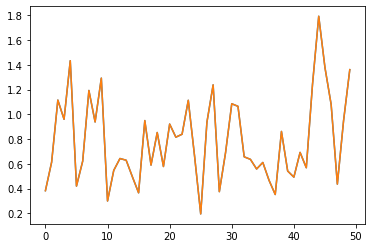

In [37]:
plt.plot(xest)
plt.plot(xestpylops)

In [38]:
nesolve = NormalEquationsInversion(Aop)

xest1 = nesolve.solve(y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)], 
                  epsRs=[1e-1, 1e-2], x0=np.zeros(nx), 
                  engine='pylops', **dict(niter=20, show=True))[0]

NormalEquationsInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]     epsI=0
-----------------------------------------------------------
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03
     6         5.1653e-01         6.5985e+03
     7         6.7217e-01         5.4724e+03
     8         7.9452e-01         3.7607e+03
     9         8.7658e-01         3.1885e+03
    10         9.5870e-01         2.8390e+03
    11         1.0049e+00         2.1910e+03
    12         1.0162e+00         2.0220e+03
    13         1.0320e+00         1.6560e+03
    14         1.0521e+00         1.2587e+03
    15         1.0685e+00         9.6100e+02
    16         1.

In [39]:
xest2 = normal_equations_inversion(Aop, Regs=[Dop, Dop], data=y, dataregs=[np.zeros(nx), np.zeros(nx)],
                                   epsRs=[1e-1, 1e-2], x0=np.zeros(nx), engine='pylops', 
                                   **dict(niter=20, show=True))[0]

NormalEquationsInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]     epsI=0
-----------------------------------------------------------
     1        -2.5795e-01         6.8784e+04
     2        -1.3424e-01         3.9387e+04
     3         2.0361e-01         2.4392e+04
     4         2.8669e-01         1.5064e+04
     5         3.8244e-01         9.3876e+03
     6         5.1653e-01         6.5985e+03
     7         6.7217e-01         5.4724e+03
     8         7.9452e-01         3.7607e+03
     9         8.7658e-01         3.1885e+03
    10         9.5870e-01         2.8390e+03
    11         1.0049e+00         2.1910e+03
    12         1.0162e+00         2.0220e+03
    13         1.0320e+00         1.6560e+03
    14         1.0521e+00         1.2587e+03
    15         1.0685e+00         9.6100e+02
    16         1.

In [40]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# RegularizedInversion

In [41]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Dop = pylops.FirstDerivative(50)

In [42]:
nesolve = RegularizedInversion(Aop)

xhist = []
nesolve.callback = lambda x: callback(x, xhist)

# scipy
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
              epsRs=[1e-1, ])
x = nesolve.run(None, engine='scipy', **dict(iter_lim=20))[0]
nesolve.finalize()
xest = x.copy()

In [43]:
# pylops
nesolve.setup(y=y, Regs=[Dop, ], dataregs=[np.zeros(nx)], 
              epsRs=[1e-1, ], show=True)
x = nesolve.run(None, engine='pylops', **dict(niter=20, show=True))[0]
nesolve.finalize(True)
xestpylops = x.copy()

RegularizedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1]
-----------------------------------------------------------
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e+01
     8        7.9452e-01         6.0386e+01     6.0386e+01
     9        8.7658e-01         5.2007e+01     5.2007e+01
    10        9.5870e-01         4.4020e+01     4.4020e+01
    11        1.0049e+00         3.7673e+01     3.7673e+01
    12        1.0162e+00         3.3271e+01     3.3271e+01
    13        1.0320e+00         2.8739e+01     2

In [44]:
xest1 = regularized_inversion_old(Aop, Regs=[Dop, ], data=y, dataregs=[np.zeros(nx)], 
                                  epsRs=[1e-1, ], x0=np.zeros(nx), **dict(iter_lim=20))

In [45]:
xest-xest1, xestpylops-xest1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-7.81046339e-10, -9.43604084e-11,  3.25564942e-09,  5.32838729e-09,
        -2.25841124e-10, -2.93940650e-09, -4.44212778e-10, -5.56112223e-09,
         5.24121613e-09,  1.81705162e-09, -8.43831449e-10, -1.80196369e-09,
         7.08401782e-10, -1.87320282e-09,  1.12352205e-09, -1.25377375e-09,
        -4.73342354e-09, -3.52775653e-09, -9.83305548e-09, -2.37191156e-09,
        -1.45472789e-09,  3.24236638e-10, -6.39410969e-10, -2.03541295e-10,
         4.30540437e-09,  2.85803892e-09, -2.19641105e-09, -4.36469927e-09,
        -5.09140508e-10, -1.75347270e-09,  3.82415388e-09, -6.32196739e-09,
        -2.23151675e-09,  1.54968660e-09,  3.14370729e-09,  5.28026511e-10,
         4.35813818e-09, -9.37216860e-10,  1.33035827e-09,  3.80848786e-09,
        -4.930

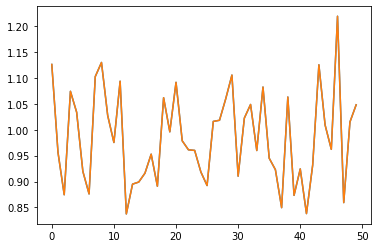

In [46]:
plt.plot(xest)
plt.plot(xestpylops)

In [47]:
nesolve = RegularizedInversion(Aop)

xest1 = nesolve.solve(y=y, Regs=[Dop, Dop], dataregs=[np.zeros(nx), np.zeros(nx)], 
                  epsRs=[1e-1, 1e-2], x0=np.zeros(nx), 
                  engine='pylops', **dict(niter=20, show=True))[0]

RegularizedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]
-----------------------------------------------------------
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e+01
     8        7.9452e-01         6.0386e+01     6.0386e+01
     9        8.7658e-01         5.2007e+01     5.2007e+01
    10        9.5870e-01         4.4020e+01     4.4020e+01
    11        1.0049e+00         3.7673e+01     3.7673e+01
    12        1.0162e+00         3.3271e+01     3.3271e+01

In [48]:
xest2 = regularized_inversion(Aop, Regs=[Dop, Dop], data=y, dataregs=[np.zeros(nx), np.zeros(nx)],
                              epsRs=[1e-1, 1e-2], x0=np.zeros(nx), engine='pylops', 
                              **dict(niter=20, show=True))[0]

RegularizedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Regs=[<50x50 FirstDerivative with dtype=float64>, <50x50 FirstDerivative with dtype=float64>]
epsRs=[0.1, 0.01]
-----------------------------------------------------------
     1       -2.5795e-01         4.7368e+02     4.7368e+02
     2       -1.3424e-01         3.1319e+02     3.1319e+02
     3        2.0361e-01         2.1717e+02     2.1717e+02
     4        2.8669e-01         1.3703e+02     1.3703e+02
     5        3.8244e-01         1.0262e+02     1.0262e+02
     6        5.1653e-01         8.3491e+01     8.3491e+01
     7        6.7217e-01         7.2001e+01     7.2001e+01
     8        7.9452e-01         6.0386e+01     6.0386e+01
     9        8.7658e-01         5.2007e+01     5.2007e+01
    10        9.5870e-01         4.4020e+01     4.4020e+01
    11        1.0049e+00         3.7673e+01     3.7673e+01
    12        1.0162e+00         3.3271e+01     3.3271e+01

In [49]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Preconditioned Inversion

In [50]:
np.random.seed(1)
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
A = A.T @ A
Aop = pylops.MatrixMult(A)
y = A @ x

Sop = pylops.Smoothing1D(5, 50)

In [51]:
psolve = PreconditionedInversion(Aop)

xhist = []
psolve.callback = lambda x: callback(x, xhist)

# scipy
psolve.setup(y=y, P=Sop)
x = psolve.run(None, engine='scipy', **dict(iter_lim=20))[0]
psolve.finalize()
xest = x.copy()

In [55]:
# pylops
psolve.setup(y=y, P=Sop, show=True)
x = psolve.run(None, engine='pylops', **dict(niter=20, show=True))[0]
psolve.finalize(True)
xestpylops = x.copy()

PreconditionedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Convolve1D with dtype=float64>
-----------------------------------------------------------
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
     9        1.4217e+00         2.4561e+01     2.4561e+01
    10        1.5393e+00         2.0756e+01     2.0756e+01
    11        1.5612e+00         1.9224e+01     1.9224e+01
    12        1.5871e+00         1.8262e+01     1.8262e+01
    13        1.6189e+00         1.6215e+01     1.6215e+01
    14

In [56]:
xest-xestpylops

array([-1.40965945e-05, -1.76346335e-05, -1.89822332e-05, -1.28944378e-05,
       -5.67894627e-06, -1.19472178e-08,  5.06896550e-06,  7.69475778e-06,
        4.21536781e-06,  4.17765649e-06,  5.48968788e-06,  6.93765198e-06,
        1.24479918e-05,  2.34811083e-05,  3.52690191e-05,  4.88716812e-05,
        6.24356050e-05,  7.01694709e-05,  7.44255449e-05,  6.88544298e-05,
        5.67084683e-05,  4.11052752e-05,  2.84540246e-05,  1.80938267e-05,
        1.21654084e-05,  1.56705296e-05,  2.21156874e-05,  2.95052984e-05,
        3.28306694e-05,  3.78693313e-05,  3.20188194e-05,  2.52982791e-05,
        1.07858472e-05, -3.41457734e-06, -1.79153722e-05, -2.57958132e-05,
       -2.93818250e-05, -2.10673430e-05, -7.73798280e-06,  4.43752274e-06,
        1.79764909e-05,  2.84668570e-05,  3.10033995e-05,  2.95827169e-05,
        3.08419367e-05,  2.90620414e-05,  2.53267828e-05,  2.09349764e-05,
        1.64463923e-05,  1.02343798e-05])

In [59]:
xest1 = preconditioned_inversion_old(Aop, Sop, data=y, x0=np.zeros(nx), **dict(iter_lim=20))

In [60]:
xest-xest1, xestpylops-xest1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 1.40965945e-05,  1.76346335e-05,  1.89822332e-05,  1.28944378e-05,
         5.67894627e-06,  1.19472178e-08, -5.06896550e-06, -7.69475778e-06,
        -4.21536781e-06, -4.17765649e-06, -5.48968788e-06, -6.93765198e-06,
        -1.24479918e-05, -2.34811083e-05, -3.52690191e-05, -4.88716812e-05,
        -6.24356050e-05, -7.01694709e-05, -7.44255449e-05, -6.88544298e-05,
        -5.67084683e-05, -4.11052752e-05, -2.84540246e-05, -1.80938267e-05,
        -1.21654084e-05, -1.56705296e-05, -2.21156874e-05, -2.95052984e-05,
        -3.28306694e-05, -3.78693313e-05, -3.20188194e-05, -2.52982791e-05,
        -1.07858472e-05,  3.41457734e-06,  1.79153722e-05,  2.57958132e-05,
         2.93818250e-05,  2.10673430e-05,  7.73798280e-06, -4.43752274e-06,
        -1.797

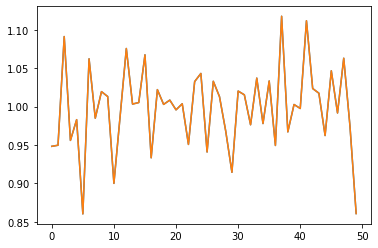

In [61]:
plt.plot(xest)
plt.plot(xestpylops)

In [63]:
nesolve = PreconditionedInversion(Aop)

xest1 = nesolve.solve(y=y, P=Sop, x0=np.zeros(nx), 
                      engine='pylops', **dict(niter=20, show=True))[0]

PreconditionedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Convolve1D with dtype=float64>
-----------------------------------------------------------
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
     9        1.4217e+00         2.4561e+01     2.4561e+01
    10        1.5393e+00         2.0756e+01     2.0756e+01
    11        1.5612e+00         1.9224e+01     1.9224e+01
    12        1.5871e+00         1.8262e+01     1.8262e+01
    13        1.6189e+00         1.6215e+01     1.6215e+01
    14

In [64]:
xest2 = preconditioned_inversion(Aop, P=Sop, data=y, x0=np.zeros(nx), engine='pylops', 
                              **dict(niter=20, show=True))[0]

PreconditionedInversion
-----------------------------------------------------------
The Operator Op has 50 rows and 50 cols
Prec=<50x50 Convolve1D with dtype=float64>
-----------------------------------------------------------
     1       -3.0815e-01         2.8474e+02     2.8474e+02
     2       -6.7294e-03         1.5380e+02     1.5380e+02
     3        4.5745e-01         8.4107e+01     8.4107e+01
     4        6.4764e-01         5.6063e+01     5.6063e+01
     5        7.3550e-01         4.9738e+01     4.9738e+01
     6        9.5151e-01         4.0758e+01     4.0758e+01
     7        1.1153e+00         3.3517e+01     3.3517e+01
     8        1.2465e+00         2.9155e+01     2.9155e+01
     9        1.4217e+00         2.4561e+01     2.4561e+01
    10        1.5393e+00         2.0756e+01     2.0756e+01
    11        1.5612e+00         1.9224e+01     1.9224e+01
    12        1.5871e+00         1.8262e+01     1.8262e+01
    13        1.6189e+00         1.6215e+01     1.6215e+01
    14

In [65]:
xest1-xest2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [72]:
import numpy as np
import pytest
from numpy.testing import assert_array_almost_equal

from pylops.basicoperators import Diagonal, HStack, Identity, MatrixMult, Smoothing1D
from pylops.optimization.leastsquaresc import (
    NormalEquationsInversion,
    PreconditionedInversion,
    RegularizedInversion,
)
from pylops.optimization.leastsquares import (
    normal_equations_inversion,
    preconditioned_inversion,
    regularized_inversion,
)


"""Compare results for normal equations and regularized inversion
when used to solve weighted least square inversion
"""
np.random.seed(10)
G = np.random.normal(0, 10, (par["ny"], par["nx"])).astype("float32") + par[
    "imag"
] * np.random.normal(0, 10, (par["ny"], par["nx"])).astype("float32")
Gop = MatrixMult(G, dtype=par["dtype"])
w = np.arange(par["ny"])
w1 = np.sqrt(w)
Weigth = Diagonal(w, dtype=par["dtype"])
Weigth1 = Diagonal(w1, dtype=par["dtype"])
x = np.ones(par["nx"]) + par["imag"] * np.ones(par["nx"])
y = Gop * x

xne = normal_equations_inversion(
    Gop, None, y, Weight=Weigth, **dict(maxiter=5, tol=1e-10)
)
xreg = regularized_inversion(
    Gop,
    None,
    y,
    Weight=Weigth1,
    **dict(damp=0, iter_lim=5, show=0)
)[0]
assert_array_almost_equal(xne, xreg, decimal=3)


TypeError: lsqr() got an unexpected keyword argument 'tol'